In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
import seaborn as sns

plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
import scipy.stats as stats
from sklearn import cluster, metrics
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet, fcluster
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist
from sklearn.metrics import silhouette_samples, silhouette_score

In [3]:
file_location = 'C:\\fx_2017_19.csv'

In [4]:
f = pd.read_csv(file_location)
df = pd.DataFrame(f)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 781 entries, 0 to 780
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 781 non-null    object 
 1   USTWBGD Index  (R1)  746 non-null    float64
 2   MXWD Index  (R1)     781 non-null    float64
 3   CO1 Comdty  (R1)     773 non-null    float64
 4   CNY Curncy  (R2)     731 non-null    float64
 5   TWD Curncy  (L2)     736 non-null    float64
 6   KRW Curncy  (R1)     733 non-null    float64
 7   SGD Curncy  (R1)     781 non-null    float64
 8   MYR Curncy  (L1)     730 non-null    float64
 9   IDR Curncy  (R1)     724 non-null    float64
 10  THB Curncy  (L3)     733 non-null    float64
 11  PHP Curncy  (R3)     728 non-null    float64
 12  INR Curncy  (R4)     723 non-null    float64
 13  RUB Curncy  (R3)     757 non-null    float64
 14  PLN Curncy  (R1)     781 non-null    float64
 15  HUF Curncy  (L3)     781 non-null    flo

In [6]:
df['Date'] = pd.to_datetime(df.Date).dt.to_period('D')

In [7]:
df.set_index('Date', inplace=True)
df.index = df.index.to_timestamp()

In [8]:
df.columns = ['usd', 'msci', 'oil', 'cny', 'twd', 'krw', 'sgd', 'myr', 'idr', 'thb', 'php', 'inr', 'rub', 
                'pln', 'huf', 'ron', 'try', 'brl', 'mxn', 'clp', 'cop', 'zar', 'ils', 'eur', 'gbp',
                'jpy', 'aud', 'nzd', 'cad', 'chf', 'nok', 'sek', 'gold', 'silver']

In [9]:
df.fillna(method='ffill', inplace=True)

In [10]:
df.head(10)

,usd,msci,oil,cny,twd,krw,sgd,myr,idr,thb,...,gbp,jpy,aud,nzd,cad,chf,nok,sek,gold,silver
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-30,115.0184,564.38,68.44,6.9868,30.074,1156.25,1.3484,4.1070,13925.0,29.967,...,0.7622,108.89,1.4285,1.4856,1.3060,0.9681,8.7997,9.3264,1515.2000,17.9423
2019-12-27,115.2705,566.84,68.16,6.9957,30.141,1161.40,1.3523,4.1272,13952.0,30.150,...,0.7645,109.44,1.4327,1.4926,1.3079,0.9750,8.8148,9.3366,1510.5601,17.7675
2019-12-26,115.6713,565.45,67.92,6.9965,30.152,1161.95,1.3540,4.1337,13958.0,30.170,...,0.7687,109.63,1.4410,1.4997,1.3118,0.9808,8.8731,9.4066,1508.7000,17.8742
2019-12-25,115.6713,563.38,67.92,6.9894,30.142,1161.95,1.3550,4.1337,13958.0,30.167,...,0.7721,109.35,1.4450,1.5076,1.3157,0.9805,8.9093,9.4125,1499.8400,17.7790
2019-12-24,115.8267,563.50,67.20,7.0073,30.170,1163.80,1.3549,4.1363,13958.0,30.160,...,0.7710,109.41,1.4444,1.5042,1.3158,0.9800,8.9094,9.4073,1499.7300,17.7540
2019-12-23,115.8460,563.43,66.39,7.0128,30.194,1164.35,1.3563,4.1427,13979.0,30.170,...,0.7732,109.39,1.4452,1.5083,1.3154,0.9820,8.9510,9.4410,1484.0500,17.4275
2019-12-20,115.7975,563.00,66.14,7.0066,30.171,1160.20,1.3552,4.1410,13989.0,30.180,...,0.7692,109.44,1.4495,1.5144,1.3161,0.9828,8.9726,9.4034,1477.4000,17.1984
2019-12-19,115.6457,561.00,66.54,7.0104,30.175,1165.70,1.3545,4.1412,13986.0,30.205,...,0.7668,109.21,1.4530,1.5144,1.3119,0.9774,8.9704,9.4230,1479.8900,17.1006
2019-12-18,115.7037,559.61,66.17,7.0050,30.203,1168.90,1.3555,4.1388,13990.0,30.222,...,0.7643,109.61,1.4587,1.5208,1.3118,0.9805,9.0141,9.4119,1474.7600,16.9933


# Feature Engineering

#### All the exchange rates are rendered in USD/XXX terms, so they are all expressed as 1 US dollar equivalents. 
#### The broad USD index used is the Fed nominal broad trade-weighted US dollar exchange rate, and the crude oil price is the Brent crude price.

In [11]:
# Generate the equivalent 1 US$ values for gold and silver
df['au$'] = 1/df.gold
df['ag$'] = 1/df.silver

In [12]:
df.drop(['gold', 'silver'], axis=1, inplace=True)

#### Dealing with financial market returns correlations, it is preferable to use the log returns, but the CAPM beta is calculated on the simple percentage returns. 

#### Furthermore, it is preferable to standardise the data for the clustering algorithms.

#### Thus, the order of data transformation will be to obtain the log returns and calculate the correlation coefficients, then get the simple returns and calculate the betas, and finally standardise the data. 

## Calculate cross-asset correlations

#### Correlations are a linear measure, so we use the log returns to reduce the likely distributional skew to FX returns, though FX returns do tend to be less skewed than equities. But we check later below.

In [13]:
df_logret = np.log(df/df.shift(-1))

In [14]:
df_logret

,usd,msci,oil,cny,twd,krw,sgd,myr,idr,thb,...,gbp,jpy,aud,nzd,cad,chf,nok,sek,au$,ag$
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-30,-0.002189,-0.004349,0.004100,-0.001273,-0.002225,-0.004444,-0.002888,-0.004906,-0.001937,-0.006088,...,-0.003013,-0.005038,-0.002936,-0.004701,-0.001454,-0.007102,-0.001714,-0.001093,-0.003067,-0.009790
2019-12-27,-0.003471,0.002455,0.003527,-0.000114,-0.000365,-0.000473,-0.001256,-0.001574,-0.000430,-0.000663,...,-0.005479,-0.001735,-0.005777,-0.004746,-0.002977,-0.005931,-0.006592,-0.007469,-0.001232,0.005987
2019-12-26,0.000000,0.003668,0.000000,0.001015,0.000332,0.000000,-0.000738,0.000000,0.000000,0.000099,...,-0.004413,0.002557,-0.002772,-0.005254,-0.002969,0.000306,-0.004071,-0.000627,-0.005890,-0.005340
2019-12-25,-0.001343,-0.000213,0.010657,-0.002558,-0.000929,-0.001591,0.000074,-0.000629,0.000000,0.000232,...,0.001426,-0.000549,0.000415,0.002258,-0.000076,0.000510,-0.000011,0.000553,-0.000073,-0.001407
2019-12-24,-0.000167,0.000124,0.012127,-0.000785,-0.000795,-0.000472,-0.001033,-0.001546,-0.001503,-0.000332,...,-0.002849,0.000183,-0.000554,-0.002722,0.000304,-0.002039,-0.004658,-0.003576,-0.010510,-0.018561
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-05,-0.007414,0.005509,0.007587,-0.008341,-0.009282,-0.016819,-0.008713,-0.002605,-0.004848,-0.001061,...,-0.008285,-0.016926,-0.009275,-0.011528,-0.005731,-0.012100,-0.012706,-0.012027,-0.014554,-0.010199
2017-01-04,-0.001735,0.008462,0.017690,-0.004288,0.000465,0.002598,-0.004777,0.000823,-0.002972,0.000000,...,-0.004424,-0.000511,-0.004497,-0.001111,-0.009653,-0.002539,-0.004963,-0.004425,-0.002492,-0.005935
2017-01-03,0.000000,0.003287,0.000000,0.000000,0.000000,-0.003907,-0.001449,0.000000,0.000000,0.000000,...,0.001964,0.000426,-0.007283,0.000416,-0.000372,0.001562,-0.000532,0.001914,0.000000,0.000000


In [15]:
# Delete the last row of null values
df_logret = df_logret.iloc[:-1]

In [16]:
correlations = df_logret.corr()

In [17]:
correlations.head(10)

,usd,msci,oil,cny,twd,krw,sgd,myr,idr,thb,...,gbp,jpy,aud,nzd,cad,chf,nok,sek,au$,ag$
usd,1.000000,-0.358860,-0.189263,0.556072,0.329560,0.314816,0.746057,0.394646,0.395150,0.421632,...,0.448659,0.322059,0.627887,0.525728,0.606353,0.499706,0.643494,0.609739,0.463689,0.433591
msci,-0.358860,1.000000,0.280718,-0.268015,-0.302759,-0.323209,-0.326680,-0.292690,-0.347894,-0.239672,...,-0.170419,0.279932,-0.390667,-0.242587,-0.333822,0.053603,-0.349874,-0.272783,0.069034,-0.087376
oil,-0.189263,0.280718,1.000000,-0.140859,-0.056344,-0.049720,-0.135085,-0.097304,-0.047919,-0.059154,...,-0.051886,0.057832,-0.154997,-0.070277,-0.309333,0.010184,-0.289293,-0.094355,-0.046946,-0.090926
cny,0.556072,-0.268015,-0.140859,1.000000,0.362301,0.321524,0.537729,0.380192,0.316420,0.356659,...,0.258872,0.152620,0.397831,0.319978,0.278701,0.228209,0.357682,0.388452,0.346696,0.386783
twd,0.329560,-0.302759,-0.056344,0.362301,1.000000,0.672843,0.313954,0.478415,0.423936,0.433186,...,0.140117,0.038909,0.215934,0.141514,0.117120,0.101044,0.211026,0.188944,0.104074,0.144188
krw,0.314816,-0.323209,-0.049720,0.321524,0.672843,1.000000,0.331395,0.481451,0.451512,0.384006,...,0.127354,0.022656,0.233599,0.133662,0.155827,0.099413,0.214746,0.182210,0.095071,0.128108
sgd,0.746057,-0.326680,-0.135085,0.537729,0.313954,0.331395,1.000000,0.402535,0.358355,0.447094,...,0.464599,0.421064,0.702292,0.635391,0.536883,0.509134,0.656672,0.607805,0.512288,0.467590
myr,0.394646,-0.292690,-0.097304,0.380192,0.478415,0.481451,0.402535,1.000000,0.499711,0.461690,...,0.173295,0.073642,0.261912,0.201628,0.204326,0.236311,0.275666,0.261757,0.166883,0.135384
idr,0.395150,-0.347894,-0.047919,0.316420,0.423936,0.451512,0.358355,0.499711,1.000000,0.386794,...,0.156439,0.045427,0.296367,0.242280,0.246388,0.154155,0.245582,0.222663,0.125994,0.126294
thb,0.421632,-0.239672,-0.059154,0.356659,0.433186,0.384006,0.447094,0.461690,0.386794,1.000000,...,0.182370,0.166310,0.323910,0.297403,0.251793,0.215805,0.304971,0.295632,0.304652,0.275338


In [18]:
usd_correlations = correlations['usd'].iloc[3:]

In [19]:
# Array of USD correlations
usd_correlations

cny    0.556072
twd    0.329560
krw    0.314816
sgd    0.746057
myr    0.394646
idr    0.395150
thb    0.421632
php    0.241916
inr    0.341644
rub    0.397479
pln    0.697661
huf    0.675360
ron    0.638544
try    0.326783
brl    0.324805
mxn    0.592595
clp    0.519167
cop    0.518398
zar    0.537798
ils    0.367509
eur    0.665191
gbp    0.448659
jpy    0.322059
aud    0.627887
nzd    0.525728
cad    0.606353
chf    0.499706
nok    0.643494
sek    0.609739
au$    0.463689
ag$    0.433591
Name: usd, dtype: float64

In [20]:
equity_correlations = correlations['msci'].iloc[3:]

In [21]:
# Array of World equity correlations
equity_correlations

cny   -0.268015
twd   -0.302759
krw   -0.323209
sgd   -0.326680
myr   -0.292690
idr   -0.347894
thb   -0.239672
php   -0.201826
inr   -0.207631
rub   -0.322676
pln   -0.261663
huf   -0.216165
ron   -0.142674
try   -0.199519
brl   -0.230952
mxn   -0.307921
clp   -0.352720
cop   -0.382595
zar   -0.402475
ils   -0.275088
eur   -0.140400
gbp   -0.170419
jpy    0.279932
aud   -0.390667
nzd   -0.242587
cad   -0.333822
chf    0.053603
nok   -0.349874
sek   -0.272783
au$    0.069034
ag$   -0.087376
Name: msci, dtype: float64

## Calculate betas

#### The CAPM beta is calculated on simple percentage returns.

In [22]:
# Generate simple percentage returns to calculate the respective betas
df_returns = (df/df.shift(-1))-1

In [23]:
df_returns

,usd,msci,oil,cny,twd,krw,sgd,myr,idr,thb,...,gbp,jpy,aud,nzd,cad,chf,nok,sek,au$,ag$
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-30,-0.002187,-0.004340,0.004108,-0.001272,-0.002223,-0.004434,-0.002884,-0.004894,-0.001935,-0.006070,...,-0.003009,-0.005026,-0.002932,-0.004690,-0.001453,-0.007077,-0.001713,-0.001092,-0.003062,-0.009742
2019-12-27,-0.003465,0.002458,0.003534,-0.000114,-0.000365,-0.000473,-0.001256,-0.001572,-0.000430,-0.000663,...,-0.005464,-0.001733,-0.005760,-0.004734,-0.002973,-0.005914,-0.006570,-0.007442,-0.001231,0.006005
2019-12-26,0.000000,0.003674,0.000000,0.001016,0.000332,0.000000,-0.000738,0.000000,0.000000,0.000099,...,-0.004404,0.002561,-0.002768,-0.005240,-0.002964,0.000306,-0.004063,-0.000627,-0.005873,-0.005326
2019-12-25,-0.001342,-0.000213,0.010714,-0.002554,-0.000928,-0.001590,0.000074,-0.000629,0.000000,0.000232,...,0.001427,-0.000548,0.000415,0.002260,-0.000076,0.000510,-0.000011,0.000553,-0.000073,-0.001406
2019-12-24,-0.000167,0.000124,0.012201,-0.000784,-0.000795,-0.000472,-0.001032,-0.001545,-0.001502,-0.000331,...,-0.002845,0.000183,-0.000554,-0.002718,0.000304,-0.002037,-0.004648,-0.003570,-0.010455,-0.018390
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-01-05,-0.007386,0.005524,0.007616,-0.008307,-0.009239,-0.016678,-0.008675,-0.002601,-0.004836,-0.001061,...,-0.008251,-0.016783,-0.009232,-0.011462,-0.005715,-0.012027,-0.012625,-0.011955,-0.014449,-0.010147
2017-01-04,-0.001733,0.008498,0.017847,-0.004279,0.000465,0.002601,-0.004766,0.000823,-0.002967,0.000000,...,-0.004414,-0.000511,-0.004487,-0.001110,-0.009607,-0.002536,-0.004951,-0.004415,-0.002489,-0.005918
2017-01-03,0.000000,0.003292,0.000000,0.000000,0.000000,-0.003899,-0.001448,0.000000,0.000000,0.000000,...,0.001966,0.000426,-0.007256,0.000416,-0.000372,0.001563,-0.000532,0.001916,0.000000,0.000000


In [24]:
# Delete the last row of null values
df_returns = df_returns.iloc[:-1]

In [25]:
# Function to calculate beta
def beta(df):
    # sets first column as the market data
    X = df.values[:, [0]]
    # insert a column of ones for the intercept
    X = np.concatenate([np.ones_like(X), X], axis=1)
    b = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(df.values[:, 1:])
    return pd.Series(b[1], df.columns[1:], name='beta')

In [26]:
usd_betas = beta(df_returns)

In [27]:
del usd_betas['msci']
del usd_betas['oil']

In [28]:
usd_betas

cny    0.558033
twd    0.256686
krw    0.544036
sgd    0.715260
myr    0.311452
idr    0.443438
thb    0.418117
php    0.249196
inr    0.465979
rub    1.064196
pln    1.422205
huf    1.403214
ron    1.052056
try    1.649685
brl    1.135889
mxn    1.597614
clp    1.277665
cop    1.350159
zar    2.010066
ils    0.473081
eur    1.028120
gbp    0.904431
jpy    0.541783
aud    1.167189
nzd    1.077526
cad    0.954496
chf    0.762400
nok    1.264779
sek    1.217132
au$    1.170299
ag$    1.828490
Name: beta, dtype: float64

## Adding implied volatility

#### The values are 25-delta 3-month implied volatility

In [29]:
v = pd.read_csv('C:\\vol_2017_19.csv')

In [30]:
df_v = pd.DataFrame(v)

In [31]:
df_v['Date'] = pd.to_datetime(df_v.Date).dt.to_period('D')

In [32]:
df_v.set_index('Date', inplace=True)
df_v.index = df_v.index.to_timestamp()

In [33]:
df_v.columns = ['cny', 'twd', 'krw', 'sgd', 'myr', 'idr', 'thb', 'php', 'inr', 'rub', 
                'pln', 'huf', 'ron', 'try', 'brl', 'mxn', 'clp', 'cop', 'zar', 'ils', 'eur', 'gbp',
                'jpy', 'aud', 'nzd', 'cad', 'chf', 'nok', 'sek', 'au$', 'ag$']

In [34]:
# Forward filing all NaN values
df_v.fillna(method='ffill', inplace=True)
df_v.head(5)

,cny,twd,krw,sgd,myr,idr,thb,php,inr,rub,...,gbp,jpy,aud,nzd,cad,chf,nok,sek,au$,ag$
Date,,,,,,,,,,,,,,,,,,,,,
2019-12-30,4.6050,3.7750,6.4350,2.7725,6.3825,5.1225,3.5350,4.8050,5.1900,8.2025,...,7.6150,5.3600,6.4925,7.185,4.3350,5.3450,7.8825,7.7000,11.7725,18.0900
2019-12-27,4.5025,3.7925,6.3750,2.7150,6.4225,5.1950,3.4950,4.7350,5.1800,8.1125,...,7.5250,5.1700,6.3450,7.060,4.2950,5.1500,7.6400,7.3675,11.8450,18.0725
2019-12-26,4.5250,3.8025,6.3525,2.7125,6.3875,5.0325,3.5450,4.7375,5.1700,8.0250,...,7.2650,5.0525,6.2350,6.945,4.2875,5.0375,7.5700,7.3650,11.7225,18.1775
2019-12-25,4.4700,3.7925,6.3375,2.7575,6.6075,5.0025,3.5400,4.6950,5.1525,8.0150,...,7.2275,5.0250,6.2800,6.990,4.2850,4.9950,7.5600,7.3300,10.5325,17.2150
2019-12-24,4.4700,3.7925,6.3375,2.7650,6.5775,5.0375,3.5225,4.7250,5.1850,8.0050,...,7.2200,5.0150,6.2650,6.965,4.2775,4.9950,7.5400,7.3150,10.4950,17.2250


In [35]:
vol_list = pd.DataFrame(df_v.mean(), columns=['vol'])

In [36]:
vol_list

,vol
cny,5.131818
twd,5.093537
krw,8.217590
sgd,4.431716
myr,6.743899
idr,7.122641
thb,5.130013
php,5.319555
inr,6.240227
rub,11.783409


## Consolidating all three features together

In [37]:
X = pd.DataFrame(data=[usd_betas, equity_correlations]).T

In [38]:
X = vol_list.merge(X, left_index=True, right_index=True, how='inner')

In [39]:
X.columns = ["vol", "usd_beta", "equity_corr"]

In [40]:
X = X[["usd_beta", "equity_corr", 'vol']]

# EDA

In [41]:
X

,usd_beta,equity_corr,vol
cny,0.558033,-0.268015,5.131818
twd,0.256686,-0.302759,5.093537
krw,0.544036,-0.323209,8.217590
sgd,0.715260,-0.326680,4.431716
myr,0.311452,-0.292690,6.743899
idr,0.443438,-0.347894,7.122641
thb,0.418117,-0.239672,5.130013
php,0.249196,-0.201826,5.319555
inr,0.465979,-0.207631,6.240227
rub,1.064196,-0.322676,11.783409


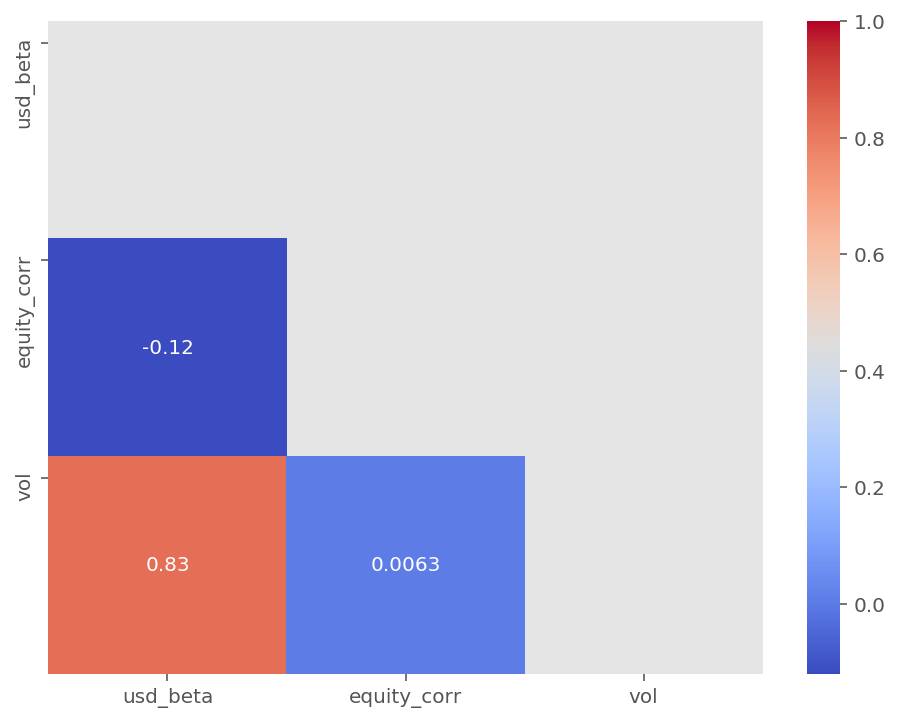

In [42]:
fig, ax = plt.subplots(figsize=(8, 6))

mask = np.zeros_like(X.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(X.corr(), mask=mask, annot=True, cmap='coolwarm', ax=ax)
ax.set_yticks(np.arange(0, df.shape[1])+0.1)
ax.set_ylim([X.shape[1], 0])
plt.show()

In [43]:
# Standardising the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [44]:
# Transformed the arrays of scaled values into a DataFrame
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

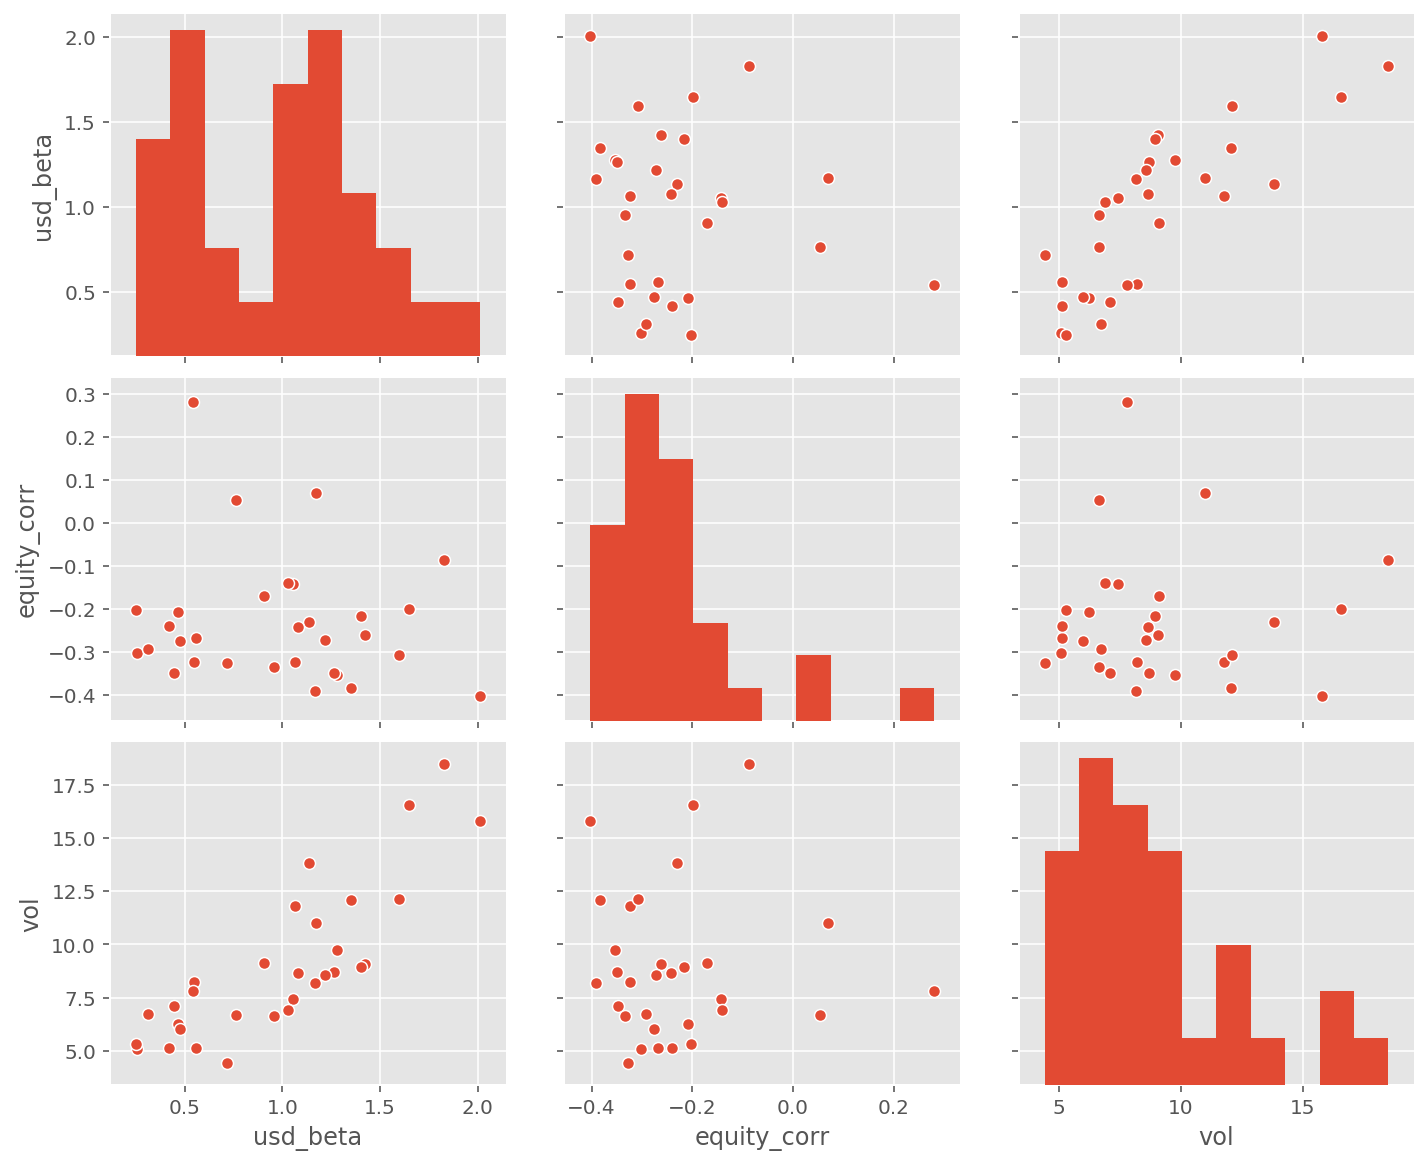

In [45]:
g=sns.pairplot(X)
g.fig.set_size_inches(10,8)
plt.show()

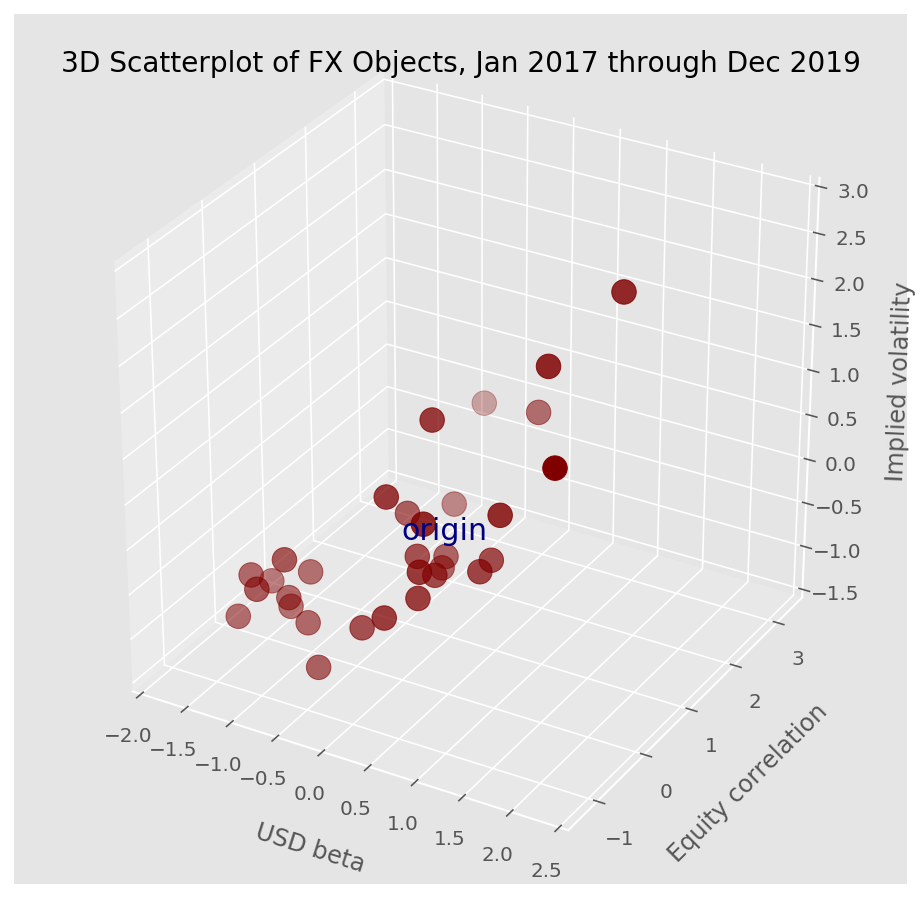

In [46]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection="3d")
ax.set_title('3D Scatterplot of FX Objects, Jan 2017 through Dec 2019', fontsize=14)

origin = [0,0,0]
ax.text(origin[0],origin[0],origin[0],"origin",size=15, color='navy')

x_points = X_scaled.usd_beta
y_points = X_scaled.equity_corr
z_points = X_scaled.vol
ax.scatter3D(x_points, y_points, z_points, s=150, color='maroon')

ax.set_xlim(-2, 2.5)
ax.set_ylim(-1.5, 3.5)
ax.set_zlim(-1.5, 3)

ax.set_xlabel('USD beta',labelpad=10,fontsize='large')
ax.set_ylabel('Equity correlation',labelpad=10,fontsize='large')
ax.set_zlabel('Implied volatility',labelpad=10,fontsize='large')

plt.show()

# Hierarchical Agglomerative Clustering

In [47]:
hier_comp = linkage(X_scaled, method='complete', metric='euclidean')

In [48]:
hier_average = linkage(X_scaled, method='average', metric='euclidean')

In [49]:
hier_ward = linkage(X_scaled, method='ward', metric='euclidean')

In [50]:
# Change the chart style...
plt.style.use('fivethirtyeight')

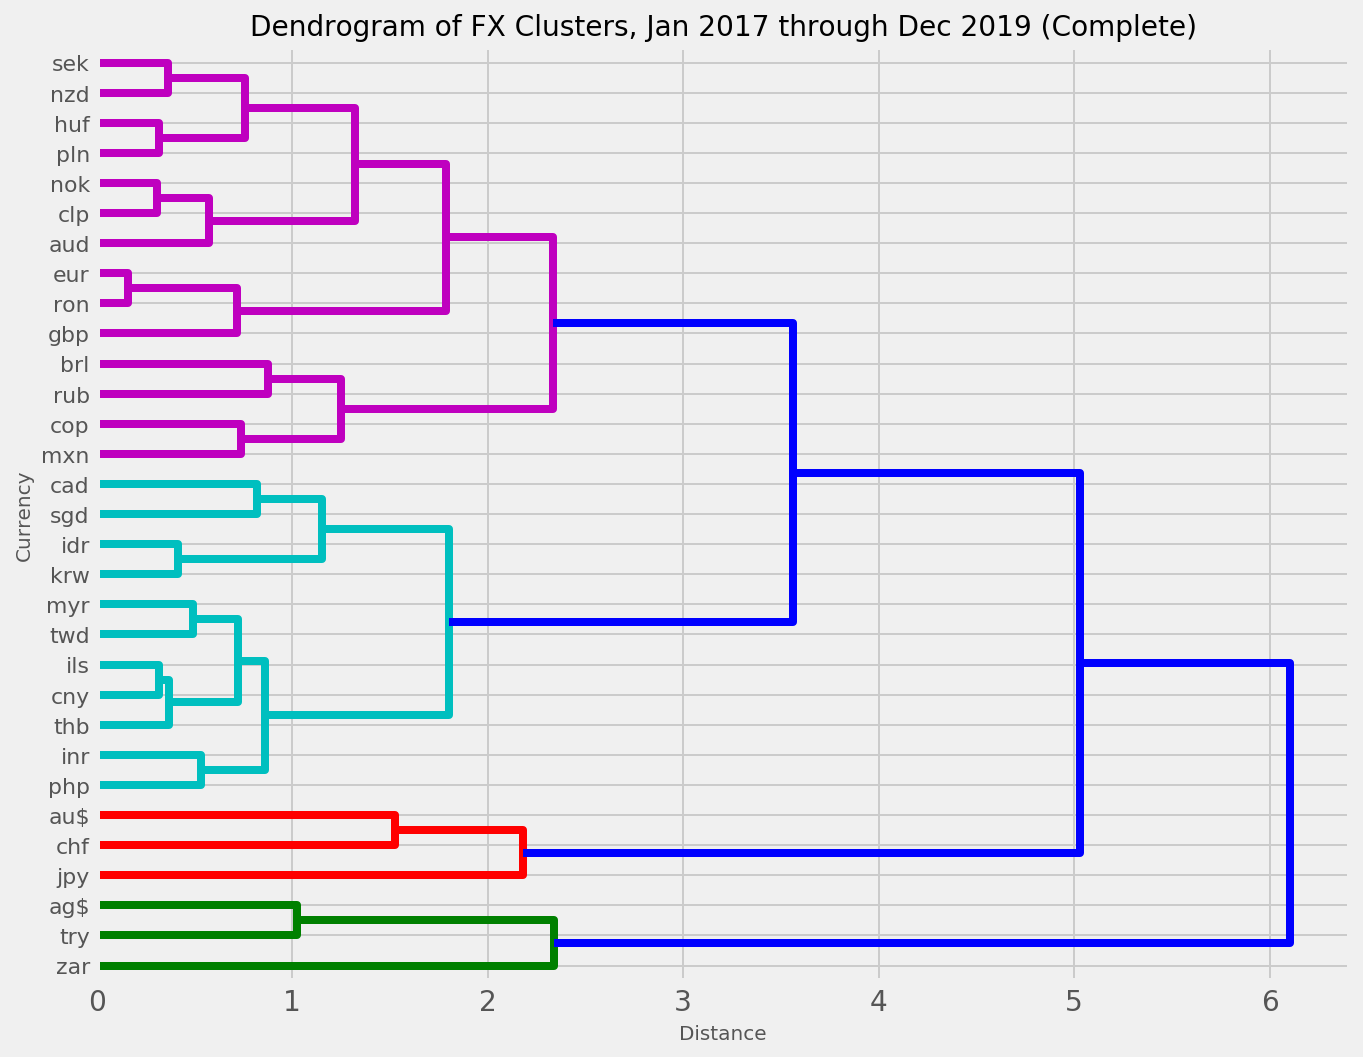

In [51]:
plt.figure(figsize=(10, 8))
plt.title('Dendrogram of FX Clusters, Jan 2017 through Dec 2019 (Complete)', fontsize=14)
plt.xlabel('Distance', fontsize=10)
plt.ylabel('Currency', fontsize=10)
dendrogram(
    hier_comp,
    orientation='right',
    #     leaf_rotation=90.,
    leaf_font_size=20,
    labels=X.index.values,
    color_threshold=3
)
plt.yticks(fontsize=11)
plt.show()

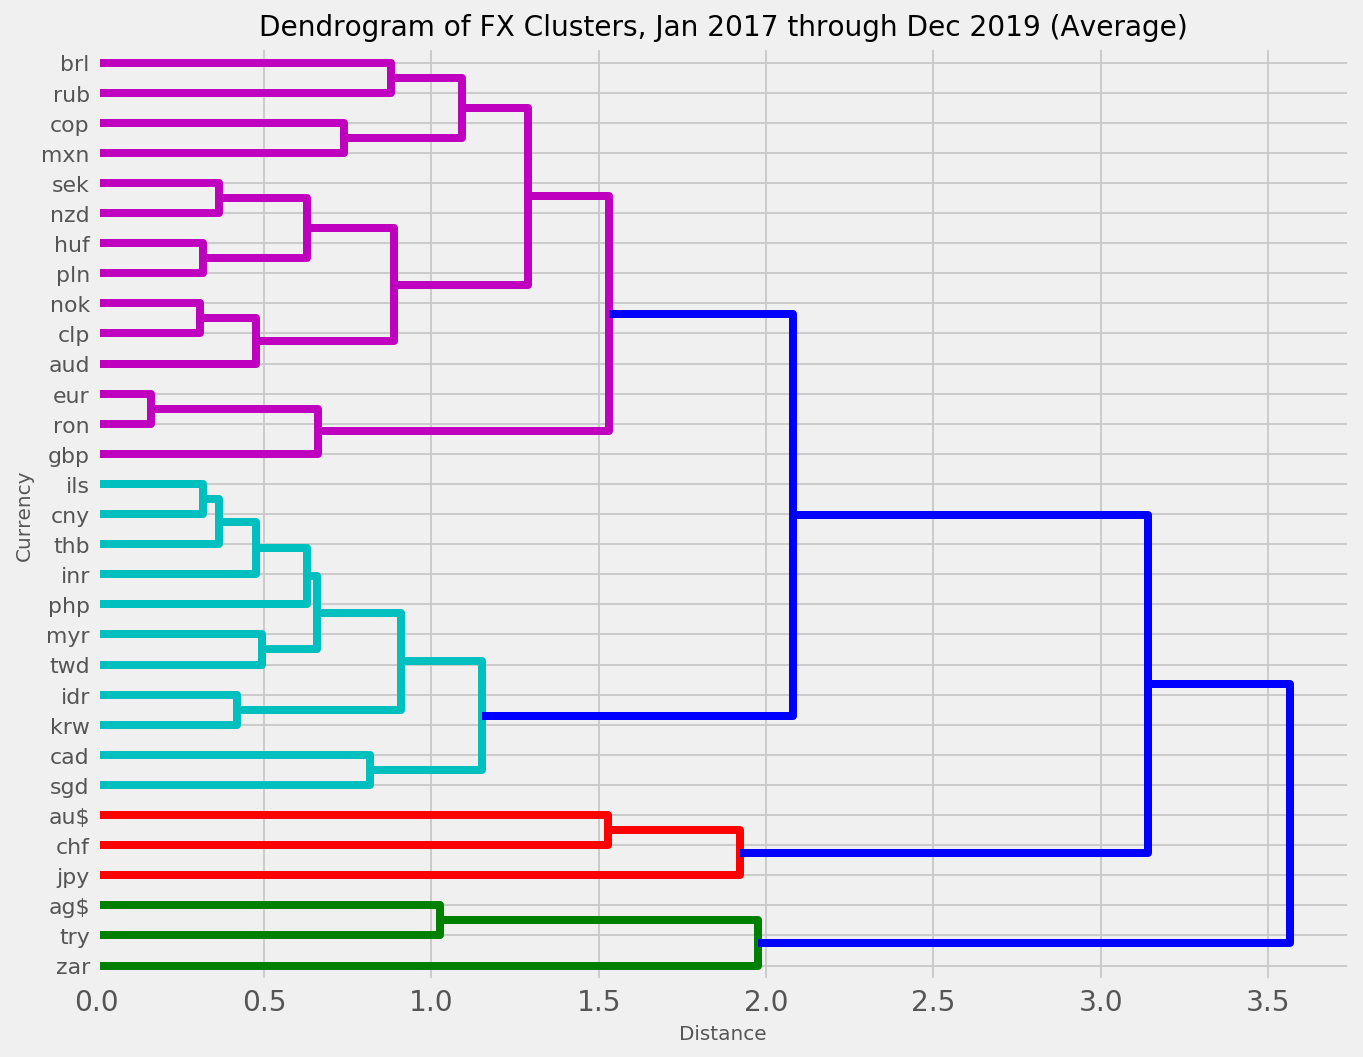

In [52]:
plt.figure(figsize=(10, 8))
plt.title('Dendrogram of FX Clusters, Jan 2017 through Dec 2019 (Average)', fontsize=14)
plt.xlabel('Distance', fontsize=10)
plt.ylabel('Currency', fontsize=10)
dendrogram(
    hier_average,
    orientation='right',
    #     leaf_rotation=90.,
    leaf_font_size=20,
    labels=X.index.values,
    color_threshold=2.0
)
plt.yticks(fontsize=11)
plt.show()

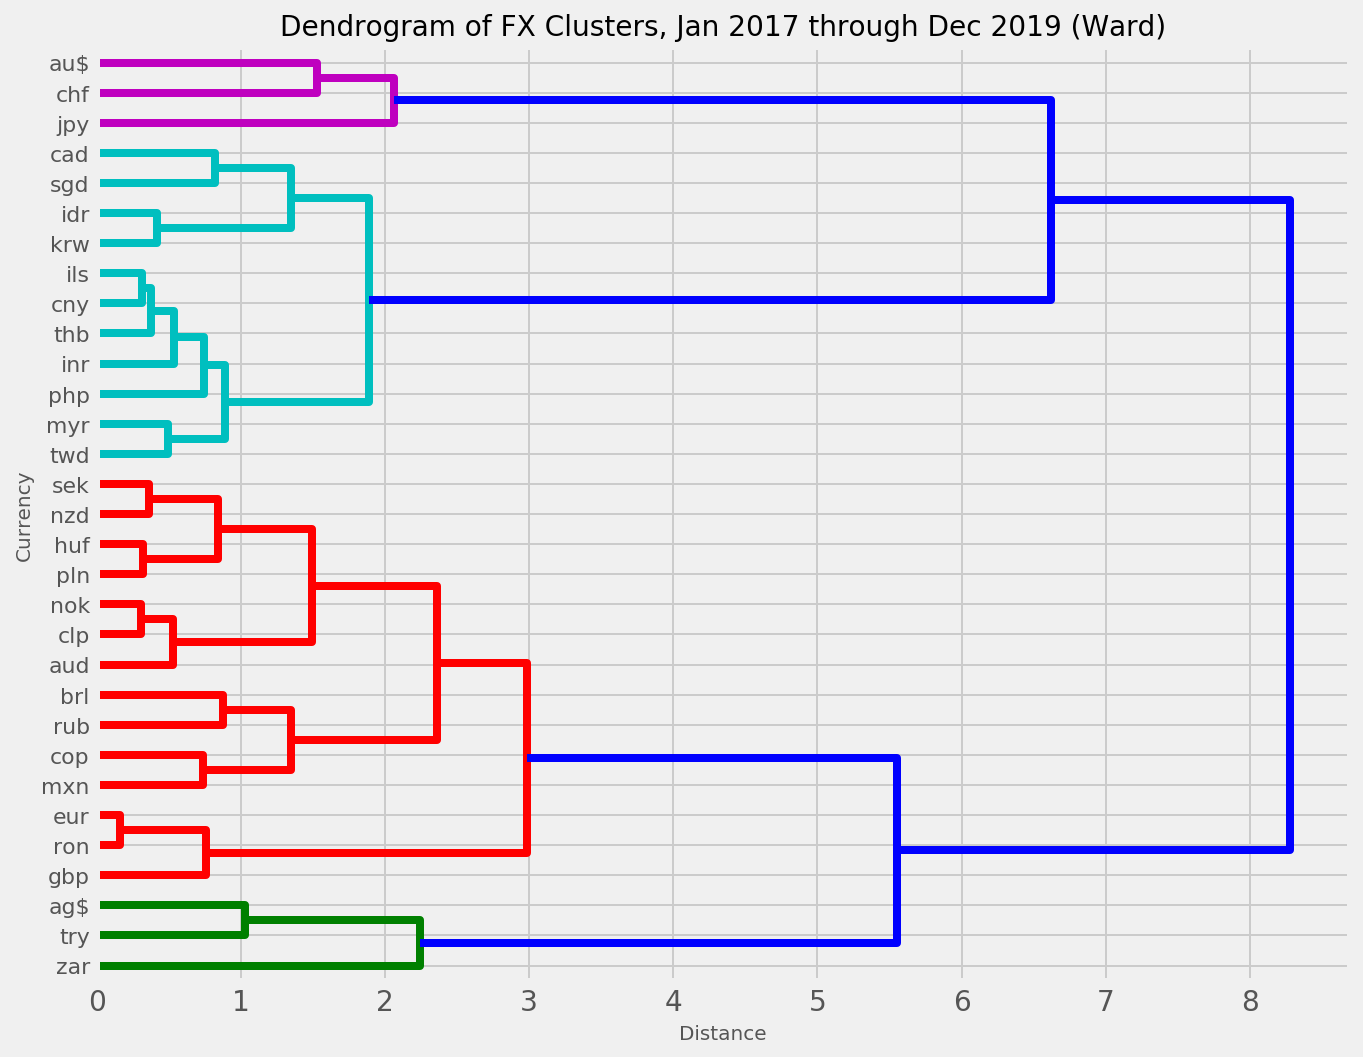

In [53]:
plt.figure(figsize=(10, 8))
plt.title('Dendrogram of FX Clusters, Jan 2017 through Dec 2019 (Ward)', fontsize=14)
plt.xlabel('Distance', fontsize=10)
plt.ylabel('Currency', fontsize=10)
dendrogram(
    hier_ward,
    orientation='right',
    #     leaf_rotation=90.,
    leaf_font_size=20,
    labels=X.index.values,
    color_threshold=5
)
plt.yticks(fontsize=11)
plt.show()

#### The various linkages - *Complete, Average & Ward* - all result in the same final 4 clusters. So no need to go into inter-cluster comparisons with the cophenetic correlations. In any event, the *Complete* linkage has the best scores among the three. So that's just use that as the final model.

In [54]:
hier_comp = linkage(X_scaled, method='complete', metric='euclidean')
c, coph_dists = cophenet(hier_comp, pdist(X, metric='euclidean'))
c

0.6409821425976302

In [55]:
hier_average = linkage(X_scaled, method='average', metric='euclidean')
c, coph_dists = cophenet(hier_average, pdist(X, metric='euclidean'))
c

0.6036975552531948

In [56]:
hier_ward = linkage(X_scaled, method='ward', metric='euclidean')
c, coph_dists = cophenet(hier_ward, pdist(X, metric='euclidean'))
c

0.394793663477764

#### The dendrogram (*Complete* linkage) above shows us how the bottoms-up agglomerative algorithm groups various currencies together during calendar years 2017 through 2019.
---
#### Four clusters:
#### *Cluster 0* - silver, TRY, ZAR
#### *Cluster 1* - NOK, CLP, AUD, SEK, NZD, HUF, PLN, EUR, RON, GBP, COP, MXN, BRL, RUB
#### *Cluster 2*  - gold, CHF, JPY
#### *Cluster 3*  - INR, THB, PHP, MYR, TWD, ILS, CNY, SGD, IDR, KRW, CAD

#### The closest geographically distinct cluster is *Cluster 3* which is composed of mainly Asian currencies

# Cluster Evaluation

In [57]:
# Looks like k=4 gives the best Silhouette score
for k in range(2, 6):
    model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='complete')  
    q = model.fit_predict(X_scaled)
    s = silhouette_score(X_scaled, q, metric='euclidean')
    print('{} number of clusters has Silhouette score of {:0.6f}'.format(k, s))

2 number of clusters has Silhouette score of 0.437171
3 number of clusters has Silhouette score of 0.418851
4 number of clusters has Silhouette score of 0.438728
5 number of clusters has Silhouette score of 0.418380


In [58]:
# Same when we use Average linkage
for k in range(2, 6):
    model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='average')  
    q = model.fit_predict(X_scaled)
    s = silhouette_score(X_scaled, q, metric='euclidean')
    print('{} number of clusters has Silhouette score of {:0.6f}'.format(k, s))

2 number of clusters has Silhouette score of 0.437171
3 number of clusters has Silhouette score of 0.418851
4 number of clusters has Silhouette score of 0.438728
5 number of clusters has Silhouette score of 0.418380


In [59]:
# Slightly different scores for the Ward linkage, due to the difference in results
for k in range(2, 6):
    model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage='ward')  
    q = model.fit_predict(X_scaled)
    s = silhouette_score(X_scaled, q, metric='euclidean')
    print('{} number of clusters has Silhouette score of {:0.6f}'.format(k, s))

2 number of clusters has Silhouette score of 0.341571
3 number of clusters has Silhouette score of 0.412570
4 number of clusters has Silhouette score of 0.438728
5 number of clusters has Silhouette score of 0.372532


In [60]:
# So we set the AH algorithm with Complete linkage and 4 clusters 
cluster_comp = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')  

In [61]:
X['clusters'] = cluster_comp.fit_predict(X_scaled)
X

,usd_beta,equity_corr,vol,clusters
cny,0.558033,-0.268015,5.131818,3
twd,0.256686,-0.302759,5.093537,3
krw,0.544036,-0.323209,8.217590,3
sgd,0.715260,-0.326680,4.431716,3
myr,0.311452,-0.292690,6.743899,3
idr,0.443438,-0.347894,7.122641,3
thb,0.418117,-0.239672,5.130013,3
php,0.249196,-0.201826,5.319555,3
inr,0.465979,-0.207631,6.240227,3
rub,1.064196,-0.322676,11.783409,1


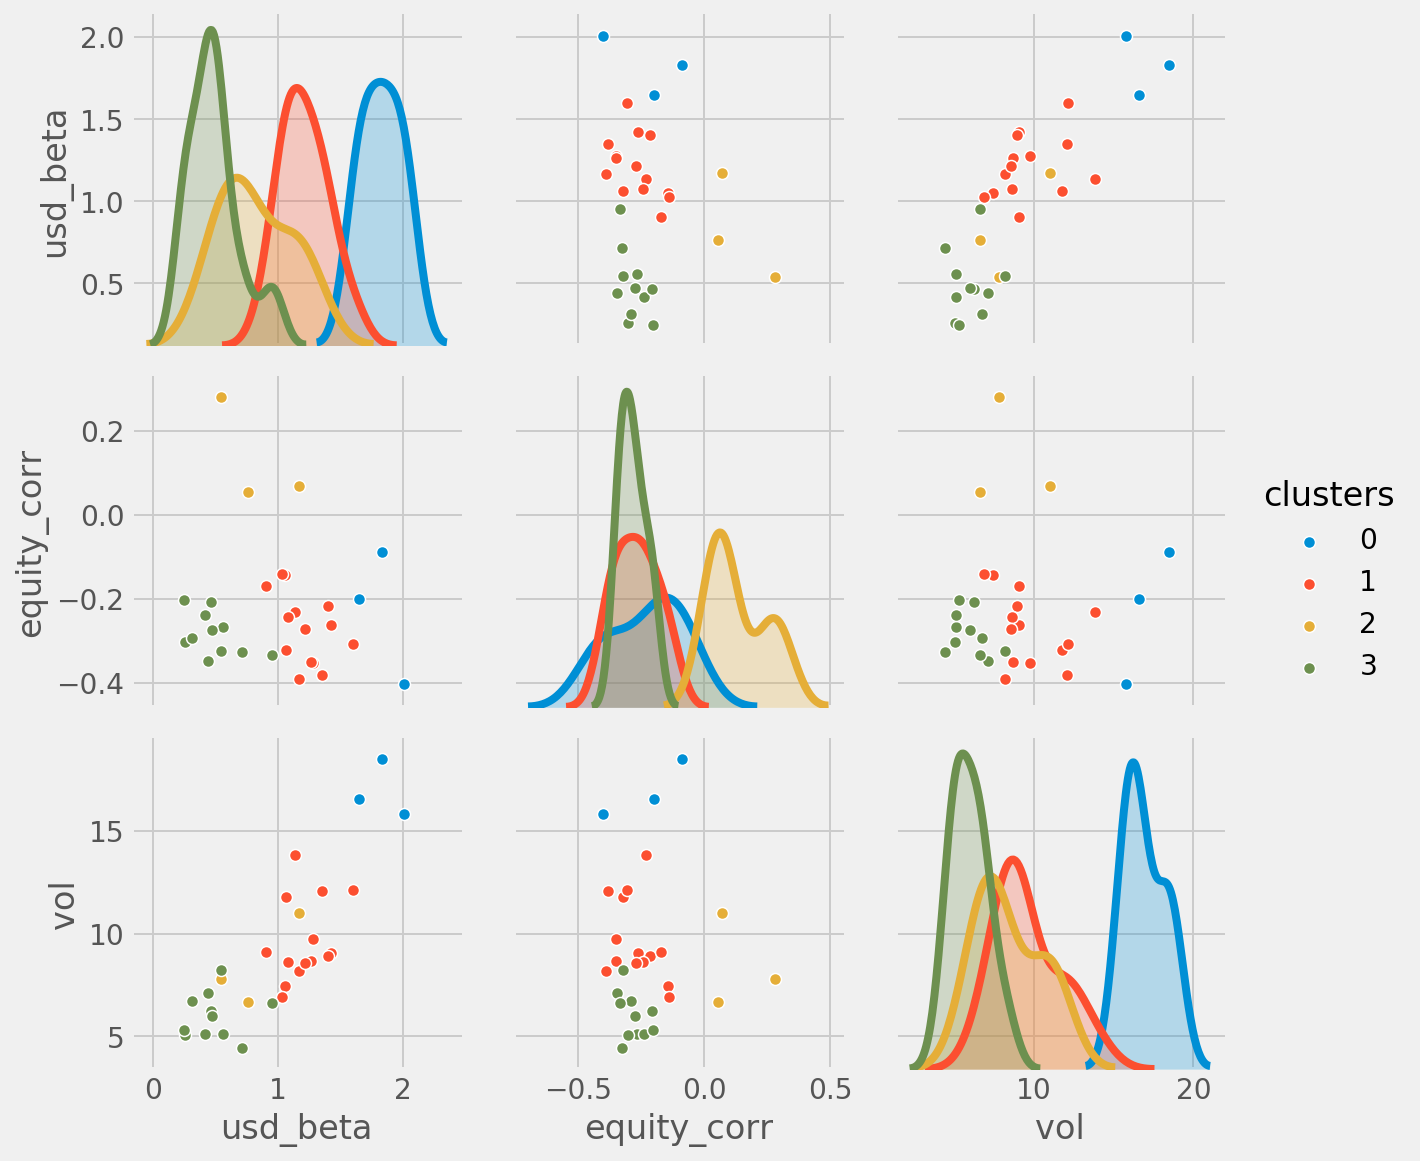

In [62]:
g=sns.pairplot(vars=[col for col in X if col!='clusters'], data=X, hue='clusters')
g.fig.set_size_inches(10,8)
plt.show()

#### The charts above makes clear the distinguishing features of the mainly Asian FX cluster (*Cluster 3* - green), which includes ILS and CAD. It has low USD beta and low implied volatility, but a negative equity correlation.

#### This may be contrasted with the "safe haven cluster" (*Cluster 2* - yellow), which has a largely similarly low volatility and low USD beta, but is positively correlated to equities (the only cluster to be thus).

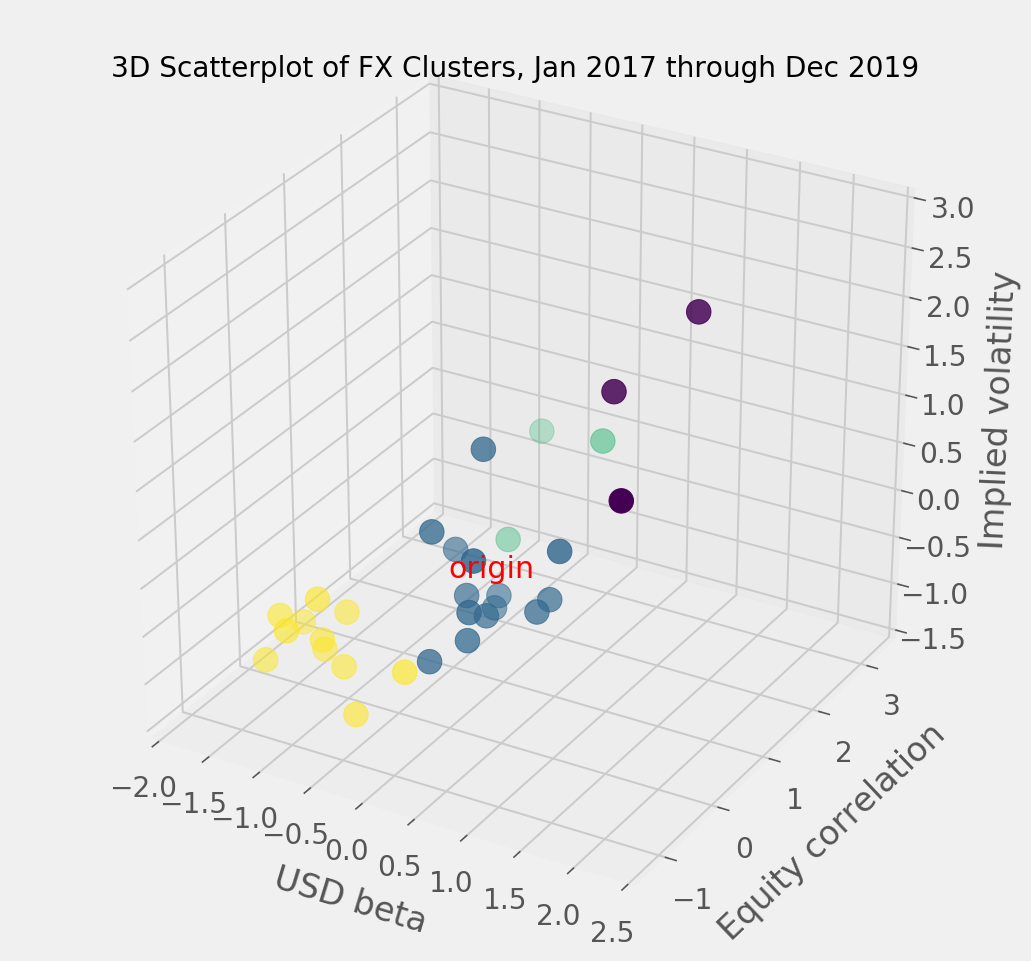

In [63]:
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection="3d")
ax.set_title('3D Scatterplot of FX Clusters, Jan 2017 through Dec 2019', fontsize=14)

origin = [0,0,0]
ax.text(origin[0],origin[0],origin[0],"origin",size=15, color='red')

x_points = X_scaled.usd_beta
y_points = X_scaled.equity_corr
z_points = X_scaled.vol
ax.scatter3D(x_points, y_points, z_points, s=150, c=X.clusters, cmap="viridis")

ax.set_xlim(-2, 2.5)
ax.set_ylim(-1.5, 3.5)
ax.set_zlim(-1.5, 3)

ax.set_xlabel('USD beta',labelpad=10,fontsize='large')
ax.set_ylabel('Equity correlation',labelpad=10,fontsize='large')
ax.set_zlabel('Implied volatility',labelpad=10,fontsize='large')

plt.show()

## Distributional characteristics of each cluster

### Let's evaluate the clusters through boxplots and two sample t-tests

In [64]:
X.groupby('clusters').agg(['mean', 'std', 'count'])

usd_beta                 equity_corr                        vol  \
              mean       std count        mean       std count       mean   
clusters                                                                    
0         1.829414  0.180192     3   -0.229790  0.159716     3  16.955681   
1         1.211584  0.187571    14   -0.270293  0.084511    14   9.650243   
2         0.824827  0.318874     3    0.134190  0.126452     3   8.487346   
3         0.489979  0.206530    11   -0.283571  0.050233    11   6.007915   

                          
               std count  
clusters                  
0         1.389383     3  
1         2.014291    14  
2         2.250620     3  
3         1.115933    11

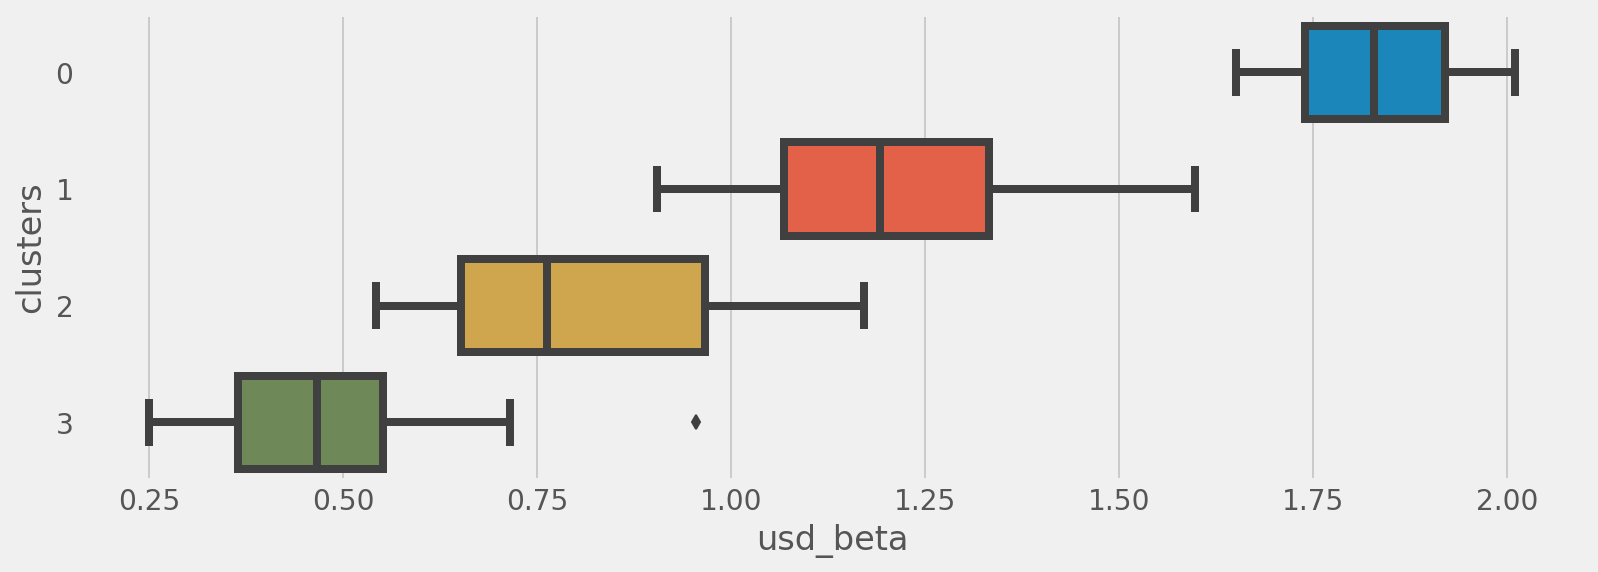

In [65]:
# Box-plots for 'usd_beta'
plt.figure(figsize=(12,4))
sns.boxplot(x='usd_beta', y='clusters', data=X, orient='h');

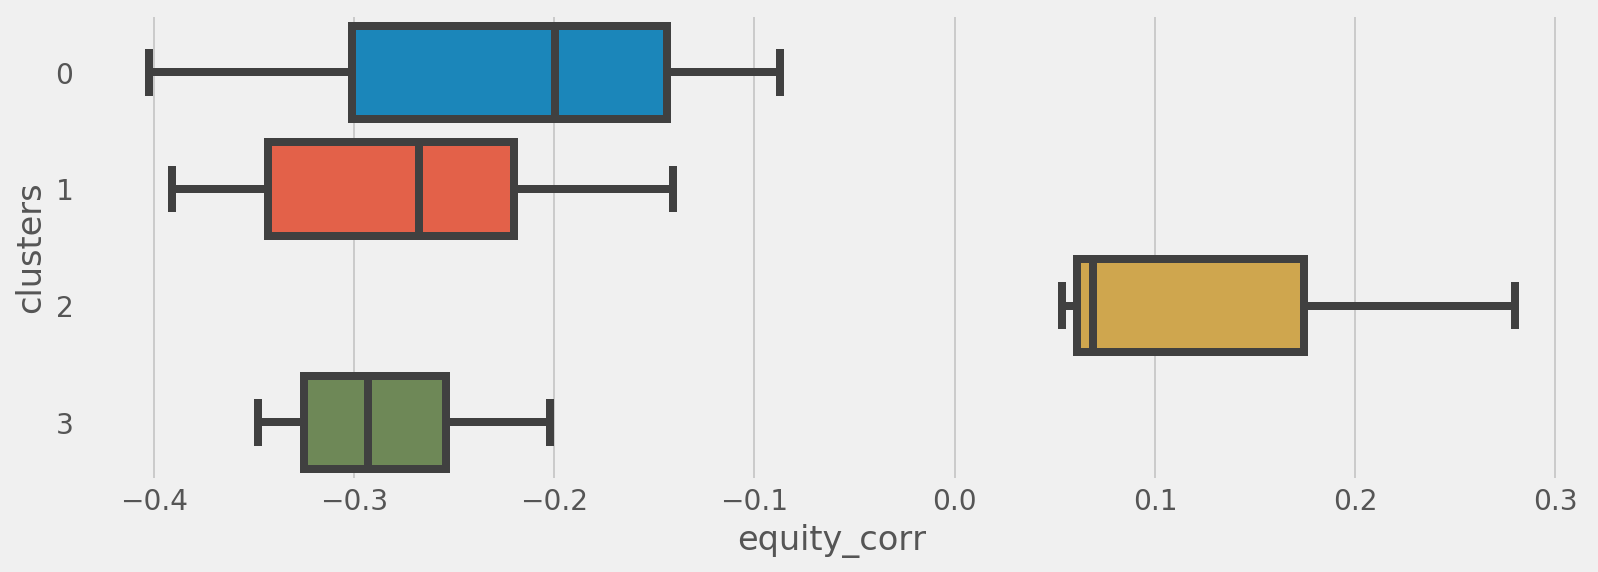

In [66]:
# Box-plots for 'equity_corr'
# Cluster 3 is statistically distinct from the others
plt.figure(figsize=(12,4))
sns.boxplot(x='equity_corr', y='clusters', data=X, orient='h');

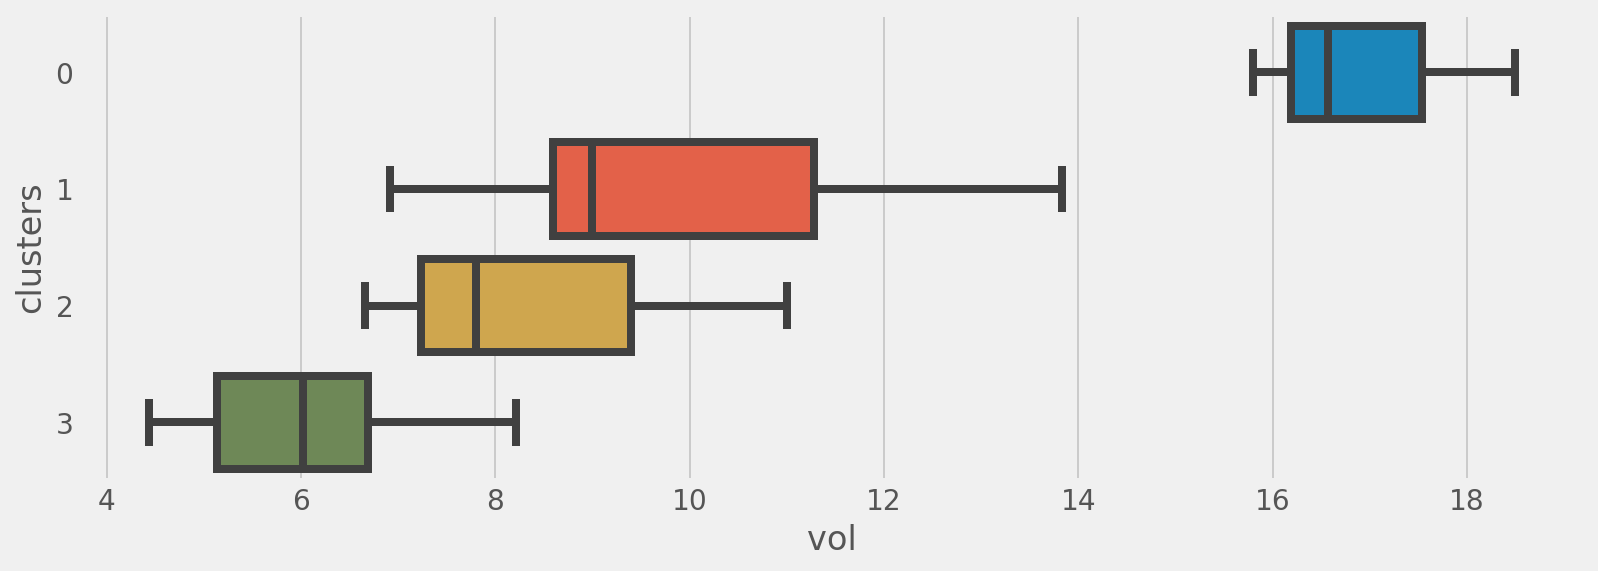

In [67]:
# Box-plots for 'vol'
plt.figure(figsize=(12,4))
sns.boxplot(x='vol', y='clusters', data=X, orient='h');

In [68]:
# Function to run t-tests across two feature columns of DataFrame
def cluster_test(i, j):
    column_list = [x for x in X.columns if x != 'clusters']
    t_test_results = {}
    
    for column in column_list:
        group1 = X.where(X.clusters == i).dropna()[column]
        group2 = X.where(X.clusters == j).dropna()[column]

        t_test_results[column] = stats.ttest_ind(group1, group2, equal_var=False)
    
    results_df = pd.DataFrame.from_dict(t_test_results, orient='Index')
    results_df.columns = ['t-statistic','p-value']
    print('Cluster {} versus Cluster {} t-test results:'.format(i, j))
    return results_df


In [69]:
# Cluster 0 is statistically distinct from Cluster 1 in usd_beta and vol
cluster_test(0, 1)

Cluster 0 versus Cluster 1 t-test results:


,t-statistic,p-value
usd_beta,5.349994,0.012648
equity_corr,0.426618,0.707118
vol,7.562088,0.001514


In [70]:
# Cluster 0 is statistically distinct from Cluster 2 in equity_corr
cluster_test(0, 2)

Cluster 0 versus Cluster 2 t-test results:


,t-statistic,p-value
usd_beta,4.750643,0.015731
equity_corr,-3.094697,0.039004
vol,5.545540,0.008713


In [71]:
# Cluster 0 is statistically distinct from Cluster 3 in usd_beta and vol
cluster_test(0, 3)

Cluster 0 versus Cluster 3 t-test results:


,t-statistic,p-value
usd_beta,11.047168,0.000664
equity_corr,0.575523,0.620407
vol,12.585540,0.001644


In [72]:
# Cluster 1 is statistically distinct from Cluster 2 in all three features
cluster_test(1, 2)

Cluster 1 versus Cluster 2 t-test results:


,t-statistic,p-value
usd_beta,2.026970,0.162715
equity_corr,-5.292792,0.022638
vol,0.826802,0.474320


In [73]:
# Cluster 1 is statistically distinct from Cluster 3 in usd_beta and vol
cluster_test(1, 3)

Cluster 1 versus Cluster 3 t-test results:


,t-statistic,p-value
usd_beta,9.026567,1.373037e-08
equity_corr,0.488291,6.302563e-01
vol,5.737395,1.079562e-05


In [74]:
# Cluster 2 is statistically distinct from Cluster 3 in equity_corr
cluster_test(2, 3)

Cluster 2 versus Cluster 3 t-test results:


,t-statistic,p-value
usd_beta,1.722925,0.202309
equity_corr,5.602885,0.025107
vol,1.847218,0.190423


#### The findings indicate that *Cluster 0* (TRY, ZAR & silver) is distinguished by extremely high *usd_beta* and *vol* values. 
#### *Cluster 2* (JPY, CHF & gold) is distinguished by positive *equity_corr* values. 
#### *Cluster 3* (mostly Asian FX) tends to have the lowest *usd_beta* and *vol* values, though with some overlap on these attributes with *Cluster 2*. 
#### *Cluster 1* is the "inbetweener" cluster, particular on *usd_beta* and *vol*, with *usd_beta* values generally higher than 1.0, unlike *Clusters 2* and *3*.

#### The results show that geography is of little use in segmenting global currencies in terms of their behavior to common financial market factors, except perhaps for non-JPY Asian currencies. The USD beta offered the best differencing factor across the four clusters, followed by implied volatility, and lastly by equity market correlation. However, one cluster ("safe haven cluster") was distinguished by having the only positive equity correlation values.